In [1]:
import pandas as pd
import numpy as np

import re
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import FreqDist
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

import yfinance as yf
from datetime import time

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib.dates as mdates

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Assessment - Machine Learning for Financial Analytics
#### Enhencement to Social Sentiment and Stock Price Correlation
by Mak Ho Wai (14/08/2025)

In [2]:
url = 'https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/appleTweets.xlsx'
appleTweets = pd.read_excel(url)

In [3]:
display(appleTweets)

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Country,Place (as appears on Bio),Followers,Following,Listed,Tweet language (ISO 639-1),Is a RT,User Mentions,Hashtags,Symbols
0,726561352882524160,2016-04-30,23:58,Warren of Wall St,WarrenofWallSt,Warren is the @SimplyWallSt mascot who helps y...,$AAPL management and CEO infographic https://t...,1.0,1.0,NaN,NaN,375.0,431.0,29.0,en,False,NaN,NaN,$AAPL
1,726560818683215872,2016-04-30,23:56,AlejandroMasari,AlejandroDinero,Passionate about coaching & teaching clients h...,the criminal media does fools investors once a...,NaN,1.0,CA,Canada,545.0,771.0,27.0,en,False,NaN,NaN,"$aapl,$spy,$qqq"
2,726560521076396032,2016-04-30,23:55,Cody Freeman,ZenTrends,NaN,@rpatel83 ha it's ok. I've been very clear sin...,NaN,NaN,NaN,NaN,1058.0,170.0,67.0,en,False,@RPatel83,NaN,$AAPL
3,726559661718179844,2016-04-30,23:51,FinBuzz,PortfolioBuzz,"Financial #bigdata crowd-sourced, crowd-curate...",Monitor your watchlist of assets for tweets - ...,NaN,NaN,GB,London,817.0,885.0,267.0,en,False,NaN,NaN,"$AAPL,$GOOGL,$MSFT,$FB,$TWTR"
4,726559467353964545,2016-04-30,23:50,Taylor,Trading_Analyst,-------- CMT Level II Candidate ------- The m...,{NEW POST} ANALYSIS + TRADE IDEAS: $AAPL $TSLA...,NaN,NaN,NaN,NaN,1785.0,22.0,56.0,en,False,NaN,NaN,"$AAPL,$TSLA,$AMZN,$NFLX,$GPRO,$TWTR"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74796,716328052892897280,2016-04-02,18:14,Daniel,LeRatton,~ Tucson #WankPuffin,“And in a world where you get a huge cheer fro...,NaN,NaN,NaN,NaN,1602.0,2029.0,108.0,en,False,NaN,NaN,$AAPL
74797,716327961641680898,2016-04-02,18:14,Computer News,computer_hware,Track all of the latest Computer News with Owl...,Why Intel Is Supporting #Apple's iPhone 7. Rea...,NaN,NaN,NaN,NaN,24.0,2.0,38.0,en,False,NaN,#Apple,$AAPL
74798,716327961641639937,2016-04-02,18:14,Peripheral News,_peripherals,Track all of the latest Peripheral News with O...,Why Intel Is Supporting #Apple's iPhone 7. Rea...,NaN,NaN,NaN,NaN,27.0,3.0,38.0,en,False,NaN,#Apple,$AAPL
74799,716326132476461058,2016-04-02,18:07,Baylee Pulliam,BayleePulliam,#Writer. #Ideator. #Digital Native. Would beat...,Here's why #Apple is flying a pirate flag to c...,NaN,NaN,US,"Louisville, Kentucky",1836.0,967.0,293.0,en,False,NaN,#Apple,$AAPL


## Data Cleaning & Engineering

In [4]:
def preprocess_apple_tweets(appleTweets):
    """
    Preprocess and engineer features for AAPL Twitter data
    Returns cleaned data without sentiment scores
    """
    
    # Create a copy to avoid modifying the original dataframe
    df = appleTweets.copy()
    
    # 1. DATA CLEANING
    print("Step 1: Data Cleaning...")
    
    # Handle missing values
    df['Favs'] = df['Favs'].fillna(0)
    df['RTs'] = df['RTs'].fillna(0)
    df['Followers'] = df['Followers'].fillna(0)
    df['Following'] = df['Following'].fillna(0)
    df['Listed'] = df['Listed'].fillna(0)
    
    # Convert date and time to datetime object
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'])
    
    # Clean tweet content - remove URLs, special characters, etc.
    def clean_tweet(text):
        if pd.isna(text):
            return ""
        # Remove URLs
        text = re.sub(r'http\S+', '', str(text))
        # Remove stock symbols (keep the text but remove $ symbol)
        text = re.sub(r'\$\w+', '', text)
        # Remove special characters except basic punctuation
        text = re.sub(r'[^\w\s.,!?]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text.lower()  # Convert to lowercase for better processing
    
    df['cleaned_tweet'] = df['Tweet content'].apply(clean_tweet)
    
    # 2. TEXT PROCESSING WITH TOKENIZATION
    print("Step 2: Text Processing and Tokenization...")
    
    # Get English stopwords
    stop_words = set(stopwords.words('english'))
    
    def process_and_tokenize(text):
        """Tokenize and process text for analysis"""
        if not text:
            return []
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and short words
        filtered_tokens = [
            token for token in tokens 
            if token not in stop_words and len(token) > 2 and token.isalpha()
        ]
        
        return filtered_tokens
    
    # Apply tokenization
    df['tokens'] = df['cleaned_tweet'].apply(process_and_tokenize)
    
    # 3. FEATURE ENGINEERING
    print("Step 3: Feature Engineering...")
    
    # Engagement metrics
    df['engagement_score'] = df['Favs'] + df['RTs'] * 2
    df['follower_engagement'] = df['engagement_score'] / (df['Followers'] + 1)
    
    # User influence metrics
    df['user_influence'] = np.log1p(df['Followers'])
    df['follow_ratio'] = df['Followers'] / (df['Following'] + 1)
    
    # Text-based features using tokens
    df['token_count'] = df['tokens'].apply(len)
    df['avg_token_length'] = df['tokens'].apply(
        lambda x: np.mean([len(token) for token in x]) if x else 0
    )
    
    # Sentiment-related word counts (using tokenization)
    positive_words = ['good', 'great', 'excellent', 'amazing', 'positive', 'bull', 'bullish', 'buy', 'strong']
    negative_words = ['bad', 'terrible', 'awful', 'negative', 'bear', 'bearish', 'sell', 'weak', 'crash']
    
    df['positive_word_count'] = df['tokens'].apply(
        lambda x: sum(1 for token in x if token in positive_words)
    )
    df['negative_word_count'] = df['tokens'].apply(
        lambda x: sum(1 for token in x if token in negative_words)
    )
    
    # Tweet characteristics
    df['original_tweet_length'] = df['Tweet content'].apply(lambda x: len(str(x)))
    df['has_hashtags'] = ~df['Hashtags'].isna()
    df['has_mentions'] = ~df['User Mentions'].isna()
    df['has_symbols'] = ~df['Symbols'].isna()
    
    # Time-based features
    df['hour_of_day'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # 4. FINAL DATA PREPARATION
    print("Step 4: Final Preparation...")
    
    # Select relevant columns for analysis
    final_columns = [
        'datetime', 'User Name', 'Followers', 'Following', 'user_influence',
        'cleaned_tweet', 'tokens', 'token_count', 'avg_token_length',
        'positive_word_count', 'negative_word_count', 'engagement_score', 
        'follower_engagement', 'hour_of_day', 'day_of_week', 'is_weekend',
        'has_hashtags', 'has_mentions', 'has_symbols', 'Favs', 'RTs',
        'Tweet language (ISO 639-1)', 'Is a RT', 'original_tweet_length'
    ]
    
    processed_df = df[final_columns].copy()
    
    # Filter for English tweets only
    processed_df = processed_df[processed_df['Tweet language (ISO 639-1)'] == 'en']
    
    print(f"Original shape: {appleTweets.shape}")
    print(f"Processed shape: {processed_df.shape}")
    print("Data processing complete!")


    processed_df.sort_values('datetime')
    return processed_df

In [5]:
# First call the process function to get cleaned data
processed_apple_tweets = preprocess_apple_tweets(appleTweets)

Step 1: Data Cleaning...
Step 2: Text Processing and Tokenization...
Step 3: Feature Engineering...
Step 4: Final Preparation...
Original shape: (74801, 19)
Processed shape: (71625, 24)
Data processing complete!


#### DateTime Conversion
- **Combined `Date` and `Hour` columns into a single `datetime` object**
- **Why favorable**: Enables time-based analysis and feature engineering (hourly, daily patterns)

#### Text Cleaning
- **Removed URLs** using regex pattern matching
- **Removed stock symbols** (keeping text but removing `$` symbols)
- **Removed special characters** except basic punctuation
- **Normalized whitespace** and converted to lowercase
- **Why favorable**: 
  - Reduces noise in text analysis
  - Standardizes text for consistent processing
  - Removes irrelevant elements that don't contribute to sentiment/content analysis


#### Engagement Metrics
- **`engagement_score`**: Combined weighted metric (Favorites + 2×Retweets)
- **`follower_engagement`**: Engagement normalized by follower count
- **Why favorable**: Captures tweet popularity and virality while accounting for user reach differences

#### User Influence Metrics
- **`user_influence`**: Logarithmic transformation of follower count
- **`follow_ratio`**: Followers to following ratio
- **Why favorable**: 
  - Logarithmic scaling handles extreme follower counts
  - Follow ratio indicates user credibility/influence level

#### Text-Based Features
- **`token_count`**: Number of meaningful words after processing
- **`avg_token_length`**: Average character length of tokens
- **Why favorable**: Quantifies content complexity and tweet substance

#### Sentiment Indicators
- **`positive_word_count`**: Count of bullish/positive keywords
- **`negative_word_count`**: Count of bearish/negative keywords
- **Why favorable**: Provides crude sentiment signals without full sentiment analysis

#### Tweet Characteristics
- **`original_tweet_length`**: Character length of original tweet
- **Boolean flags** for hashtags, mentions, and symbols presence
- **Why favorable**: Captures structural elements that affect engagement and visibility

#### Time-Based Features
- **`hour_of_day`**: Extracted hour component (0-23)
- **`day_of_week`**: Day of week (0-6)
- **`is_weekend`**: Binary weekend indicator
- **Why favorable**: Enables analysis of temporal patterns in tweet engagement and sentiment


#### Tokenization & Filtering
- **English stopword removal** using NLTK
- **Short word filtering** (<3 characters)
- **Non-alphabetic token removal**
- **Why favorable**: 
  - Focuses analysis on meaningful content words
  - Reduces dimensionality for text analysis
  - Improves quality of derived text features


#### Column Selection
- **Retained only relevant features** for subsequent analysis
- **Why favorable**: Reduces memory usage and focuses on predictive features

#### Language Filtering
- **Filtered for English tweets only** using ISO language codes
- **Why favorable**: Ensures consistency in text processing and analysis

### Text tokens Analytics

In [6]:
# Additional function for text analysis
def analyze_tweet_content(processed_df):
    """
    Perform additional text analysis on the processed tweets
    """
    # Combine all tokens
    all_tokens = [token for sublist in processed_df['tokens'] for token in sublist]
    
    # Get most common words
    freq_dist = FreqDist(all_tokens)
    common_words = freq_dist.most_common(20)
    
    print("Most common words (excluding stopwords):")
    for word, count in common_words:
        print(f"{word}: {count}")
    
    return common_words

In [7]:
# Optional: perform text analysis
common_words = analyze_tweet_content(processed_apple_tweets)

Most common words (excluding stopwords):
apple: 25603
read: 8606
iphone: 6927
stocks: 6083
teams: 5631
buy: 4993
billion: 4807
still: 4676
philstockworld: 4654
stock: 4334
could: 4295
earnings: 4216
apples: 3749
trading: 3694
new: 3500
cash: 3228
watch: 2867
market: 2856
valaafshar: 2651
amp: 2363


### Top Word Frequency Insights

#### Dominant Brand & Product Mentions
*   **`apple: 25603`** - The overwhelming frequency of "Apple" itself confirms the dataset is correctly focused on the target company, serving as a strong anchor for the topic.
*   **`iphone: 6927`** - As Apple's flagship product, its high mention count is expected and highlights its central role in driving conversations about the company's stock.
*   **`watch: 2867`** - The significant mention of "Watch" indicates the Apple Watch is also a notable topic of discussion among investors and users.

#### Core Financial & Investment Terminology
*   **`stocks: 6083`**, **`stock: 4334`** - The high combined frequency of these terms is the clearest possible indicator that the discourse is fundamentally centered on **investment and stock market performance**.
*   **`buy: 4993`** - This is a strongly bullish signal. The high prevalence of "buy" suggests a significant portion of the conversation is advocating for or discussing purchasing Apple stock.
*   **`earnings: 4216`** - A key driver of stock price movement. Its common appearance shows traders and investors are heavily focused on Apple's financial results.
*   **`trading: 3694`**, **`market: 2856`** - These terms further cement the context of stock market activity and daily price action.

#### Quantitative & Business Metrics
*   **`billion: 4807`** - This term almost exclusively appears in the context of large financial figures (e.g., revenue, market cap, cash reserves). Its frequency underscores discussions about Apple's massive scale and financial power.
*   **`cash: 3228`** - A direct reference to Apple's famously large cash hoard, a critical point of analysis for investors assessing the company's health and potential for dividends/buybacks.

#### Action & Speculation
*   **`read: 8606`** - This likely originates from phrases like "read more" or "read the article," suggesting a high volume of tweets are **sharing links to news articles or analysis** about Apple.
*   **`could: 4295`** - This word is a marker of **speculation and prediction**, indicating users are often discussing potential future outcomes for Apple's stock price or business moves.

#### Notable Entities
*   **`philstockworld: 4654`**, **`valaafshar: 2651`** - These are likely prominent accounts (e.g., financial news outlets, analysts, or executives) whose mentions are being retweeted or discussed heavily, influencing the conversation.

## Sentiment Scoring

#### Sentiment Analysis Implementation: Why VADER from NLTK?

I chose to implement the sentiment analysis core using NLTK's VADER (Valence Aware Dictionary and sEntiment Reasoner) instead of a simpler alternative like TextBlob for a few critical reasons that directly enhance the accuracy and nuance of our results:

*   **Domain Superiority for Social Text:** VADER's lexicon is specifically tuned for microblog-like content (e.g., tweets, status updates). It inherently understands modern linguistic patterns that generic models miss, including:
    *   **Slang and Acronyms:** Terms like `'LOL'`, `'MEH'`, `'SMH'`.
    *   **Emoticons:** `:)`, `:(`, `-_-`.
    *   **Degree Modifiers:** It correctly interprets that `"The movie is GOOD"` is less intense than `"The movie is ABSOLUTELY INCREDIBLE!"`.
    *   **Punctuation Impact:** It recognizes that capitalization (`"LOVE THIS"` vs `"love this"`) and exclamation points (`"great."` vs `"great!!!"`) change sentiment intensity.

*   **Granular, Explainable Output:** Unlike TextBlob which returns a single polarity score, VADER provides a compound score (normalized summary metric) **plus** decomposed positive, negative, and neutral proportions. This multi-dimensional output allows for much richer analysis and feature engineering, which I immediately leverage.

*   **Foundation for Enhanced Logic:** VADER's robust compound score provides the perfect foundation for our custom `enhanced_sentiment` feature. By combining its nuanced assessment with a simple weighted word-count differential, we create a hybrid model that is both context-aware and reinforced by term frequency. This level of customization and enhancement is not as straightforward or effective with the more opaque scoring of TextBlob.

In short, VADER from NLTK is simply the right tool for this job. It provides the necessary linguistic granularity for social media data and enables a more sophisticated, explainable, and accurate sentiment pipeline than a general-purpose model would allow.

In [8]:
def calculate_sentiment_scores(processed_df):
    """
    Calculate sentiment scores for preprocessed tweets
    """
    print("Calculating sentiment scores...")
    
    # Initialize VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
    
    def get_sentiment_scores(text):
        return sia.polarity_scores(text)
    
    # Apply sentiment analysis on cleaned text
    sentiment_scores = processed_df['cleaned_tweet'].apply(get_sentiment_scores)
    
    # Extract sentiment scores
    processed_df['sentiment_compound'] = sentiment_scores.apply(lambda x: x['compound'])
    processed_df['sentiment_positive'] = sentiment_scores.apply(lambda x: x['pos'])
    processed_df['sentiment_negative'] = sentiment_scores.apply(lambda x: x['neg'])
    processed_df['sentiment_neutral'] = sentiment_scores.apply(lambda x: x['neu'])
    
    # Enhanced sentiment using both VADER and word counts
    processed_df['enhanced_sentiment'] = processed_df['sentiment_compound'] + 0.1 * (
        processed_df['positive_word_count'] - processed_df['negative_word_count']
    )
    
    # Categorical sentiment labels
    processed_df['sentiment_label'] = pd.cut(processed_df['enhanced_sentiment'],
                                           bins=[-1, -0.1, 0.1, 1],
                                           labels=['negative', 'neutral', 'positive'])
    
    print("Sentiment analysis complete!")
    
    return processed_df

In [9]:
# Then call the sentiment function to get scores
processed_apple_tweets_with_sentiment = calculate_sentiment_scores(processed_apple_tweets)

Calculating sentiment scores...
Sentiment analysis complete!


In [10]:
processed_apple_tweets_with_sentiment = processed_apple_tweets_with_sentiment.sort_values('datetime')
display(processed_apple_tweets_with_sentiment)
print(processed_apple_tweets_with_sentiment.columns)

,datetime,User Name,Followers,Following,user_influence,cleaned_tweet,tokens,token_count,avg_token_length,positive_word_count,...,RTs,Tweet language (ISO 639-1),Is a RT,original_tweet_length,sentiment_compound,sentiment_positive,sentiment_negative,sentiment_neutral,enhanced_sentiment,sentiment_label
74800,2016-04-02 18:06:00,Swing Trade Warrior,76860.0,44366.0,11.249754,day trading chatroom for free! stocks trading,"[day, trading, chatroom, free, stocks, trading]",6,5.833333,0,...,6.0,en,False,140,0.5562,0.374,0.000,0.626,0.5562,positive
74799,2016-04-02 18:07:00,Baylee Pulliam,1836.0,967.0,7.515889,heres why apple is flying a pirate flag to cel...,"[heres, apple, flying, pirate, flag, celebrate...",7,6.571429,0,...,0.0,en,False,130,0.5719,0.252,0.000,0.748,0.5719,positive
74797,2016-04-02 18:14:00,Computer News,24.0,2.0,3.218876,why intel is supporting apples iphone 7. read ...,"[intel, supporting, apples, iphone, read]",5,6.200000,0,...,0.0,en,False,83,0.4404,0.266,0.000,0.734,0.4404,positive
74798,2016-04-02 18:14:00,Peripheral News,27.0,3.0,3.332205,why intel is supporting apples iphone 7. read ...,"[intel, supporting, apples, iphone, read]",5,6.200000,0,...,0.0,en,False,83,0.4404,0.266,0.000,0.734,0.4404,positive
74796,2016-04-02 18:14:00,Daniel,1602.0,2029.0,7.379632,and in a world where you get a huge cheer from...,"[world, get, huge, cheer, audience, youve, ann...",10,5.400000,0,...,0.0,en,False,111,0.6808,0.272,0.000,0.728,0.6808,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2016-04-30 23:50:00,Taylor,1785.0,22.0,7.487734,new post analysis trade ideas click the link gt,"[new, post, analysis, trade, ideas, click, link]",7,4.857143,0,...,0.0,en,False,140,0.2732,0.208,0.000,0.792,0.2732,positive
3,2016-04-30 23:51:00,FinBuzz,817.0,885.0,6.706862,monitor your watchlist of assets for tweets us...,"[monitor, watchlist, assets, tweets, tech, gia...",6,6.333333,0,...,0.0,en,False,113,0.1779,0.159,0.000,0.841,0.1779,positive
2,2016-04-30 23:55:00,Cody Freeman,1058.0,170.0,6.965080,rpatel83 ha its ok. ive been very clear since ...,"[ive, clear, since, sell, got, plenty, evidenc...",8,5.000000,0,...,0.0,en,False,112,0.5095,0.292,0.125,0.584,0.4095,positive
1,2016-04-30 23:56:00,AlejandroMasari,545.0,771.0,6.302619,the criminal media does fools investors once a...,"[criminal, media, fools, investors, backtestin...",6,7.166667,0,...,1.0,en,False,137,-0.7840,0.000,0.434,0.566,-0.7840,negative


Index(['datetime', 'User Name', 'Followers', 'Following', 'user_influence',
       'cleaned_tweet', 'tokens', 'token_count', 'avg_token_length',
       'positive_word_count', 'negative_word_count', 'engagement_score',
       'follower_engagement', 'hour_of_day', 'day_of_week', 'is_weekend',
       'has_hashtags', 'has_mentions', 'has_symbols', 'Favs', 'RTs',
       'Tweet language (ISO 639-1)', 'Is a RT', 'original_tweet_length',
       'sentiment_compound', 'sentiment_positive', 'sentiment_negative',
       'sentiment_neutral', 'enhanced_sentiment', 'sentiment_label'],
      dtype='object')


### Merge with Return
Instead of simply keying the sentiment scores to the same-day return, this method assigns the return based on the tweet's posting time to better approximate a realistic reaction. Tweets posted during active trading hours (9:30 AM to 4:00 PM) are keyed to the daily return of that same day. Tweets posted outside of trading hours (e.g., pre-market, after-hours, or on a weekend) are keyed to the next available trading day's gap return (the return from the previous day's close to the next day's open).

This approach, while not perfect (as it introduces a look-ahead bias for after-hours tweets since we cannot buy before the tweet), provides a more testable nuanced linkage between sentiment and market movement.

In [11]:
# Download AAPL historical data
aapl = yf.download('AAPL', start='2016-01-01', end='2023-12-31')

# Check if aapl has multi-level columns and flatten them
if isinstance(aapl.columns, pd.MultiIndex):
    aapl.columns = aapl.columns.get_level_values(0)  # Flatten multi-level columns

aapl['daily_return'] = aapl['Close'].pct_change()  # Calculate daily returns
aapl['gap_return'] = aapl['Open'] / aapl['Close'].shift(1) - 1  # Calculate gap return (open vs previous close)

# Reset index to make Date a column and ensure it's a single-level dataframe
aapl = aapl.reset_index()
aapl['Date'] = pd.to_datetime(aapl['Date'])

# Convert tweet datetime to datetime if not already
df = processed_apple_tweets_with_sentiment.copy()
df['datetime'] = pd.to_datetime(df['datetime'])

# Define trading hours
market_open = time(9, 30, 0)
market_close = time(16, 0, 0)
pre_market_start = time(4, 0, 0)  # Early pre-market
after_market_end = time(20, 0, 0)  # Late after-market

def get_trading_date_and_return_type(dt):
    """
    Determine the appropriate trading date and return type for a tweet.
    Returns: (trading_date, return_type)
    where return_type is 'gap_return' or 'daily_return'
    """
    dt = pd.Timestamp(dt)
    dt_time = dt.time()
    dt_date = dt.normalize()
    
    # Check if it's during trading hours (9:30 AM - 4:00 PM) on a weekday
    if dt.weekday() < 5 and market_open <= dt_time <= market_close:
        return dt_date, 'daily_return'
    
    # Check if it's pre-market (before 9:30 AM) on a weekday
    elif dt.weekday() < 5 and pre_market_start <= dt_time < market_open:
        return dt_date, 'gap_return'
    
    # All other cases (after-market, weekends, overnight):
    # Find next business day and use gap return
    next_bday = dt + pd.offsets.BDay(1)
    return next_bday.normalize(), 'gap_return'

# Apply the function to get trading dates and return types
result = df['datetime'].apply(get_trading_date_and_return_type)
df['trading_date'] = result.apply(lambda x: x[0])
df['return_type'] = result.apply(lambda x: x[1])

# Make sure trading_date is datetime
df['trading_date'] = pd.to_datetime(df['trading_date'])

# Prepare AAPL data with both return types
aapl_returns = aapl[['Date', 'daily_return', 'gap_return']].copy()

# Check and ensure both dataframes have single-level columns
if isinstance(aapl_returns.columns, pd.MultiIndex):
    aapl_returns.columns = aapl_returns.columns.get_level_values(0)

# Perform the merge
merged_df = df.merge(
    aapl_returns,
    left_on='trading_date',
    right_on='Date',
    how='left'
)

# Select the appropriate return based on return_type
merged_df['final_return'] = merged_df.apply(
    lambda row: row['gap_return'] if row['return_type'] == 'gap_return' else row['daily_return'],
    axis=1
)

# Drop temporary columns
columns_to_drop = ['trading_date', 'Date', 'return_type', 'daily_return', 'gap_return']
columns_to_drop = [col for col in columns_to_drop if col in merged_df.columns]
merged_df = merged_df.drop(columns_to_drop, axis=1)
merged_df = merged_df.rename(columns={'final_return': 'return'})

display(merged_df.head())
print(f"\nMissing returns: {merged_df['return'].isnull().sum()}")
print(f"Total tweets: {len(merged_df)}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,datetime,User Name,Followers,Following,user_influence,cleaned_tweet,tokens,token_count,avg_token_length,positive_word_count,...,Tweet language (ISO 639-1),Is a RT,original_tweet_length,sentiment_compound,sentiment_positive,sentiment_negative,sentiment_neutral,enhanced_sentiment,sentiment_label,return
0,2016-04-02 18:06:00,Swing Trade Warrior,76860.0,44366.0,11.249754,day trading chatroom for free! stocks trading,"[day, trading, chatroom, free, stocks, trading]",6,5.833333,0,...,en,False,140,0.5562,0.374,0.0,0.626,0.5562,positive,0.00391
1,2016-04-02 18:07:00,Baylee Pulliam,1836.0,967.0,7.515889,heres why apple is flying a pirate flag to cel...,"[heres, apple, flying, pirate, flag, celebrate...",7,6.571429,0,...,en,False,130,0.5719,0.252,0.0,0.748,0.5719,positive,0.00391
2,2016-04-02 18:14:00,Computer News,24.0,2.0,3.218876,why intel is supporting apples iphone 7. read ...,"[intel, supporting, apples, iphone, read]",5,6.200000,0,...,en,False,83,0.4404,0.266,0.0,0.734,0.4404,positive,0.00391
3,2016-04-02 18:14:00,Peripheral News,27.0,3.0,3.332205,why intel is supporting apples iphone 7. read ...,"[intel, supporting, apples, iphone, read]",5,6.200000,0,...,en,False,83,0.4404,0.266,0.0,0.734,0.4404,positive,0.00391
4,2016-04-02 18:14:00,Daniel,1602.0,2029.0,7.379632,and in a world where you get a huge cheer from...,"[world, get, huge, cheer, audience, youve, ann...",10,5.400000,0,...,en,False,111,0.6808,0.272,0.0,0.728,0.6808,positive,0.00391



Missing returns: 0
Total tweets: 71625


A display to check how the matching works

In [12]:
# Show distribution of return types
print("\nReturn type distribution:")
print(df['return_type'].value_counts())

# Show sample of tweet timing and return types (including weekends)
print("\nSample of weekend tweet timing and return types:")
weekend_sample = df[df['datetime'].dt.weekday >= 5].head(10).copy()
weekend_sample['time_only'] = weekend_sample['datetime'].dt.time
weekend_sample['day_of_week'] = weekend_sample['datetime'].dt.day_name()
print(weekend_sample[['datetime', 'time_only', 'day_of_week', 'return_type']])

# Show sample of weekday after-market tweets
print("\nSample of weekday after-market tweet timing and return types:")
after_market_sample = df[
    (df['datetime'].dt.weekday < 5) & 
    (df['datetime'].dt.time > market_close)
].head(10).copy()
after_market_sample['time_only'] = after_market_sample['datetime'].dt.time
after_market_sample['day_of_week'] = after_market_sample['datetime'].dt.day_name()
print(after_market_sample[['datetime', 'time_only', 'day_of_week', 'return_type']])


Return type distribution:
return_type
gap_return      52230
daily_return    19395
Name: count, dtype: int64

Sample of weekend tweet timing and return types:
                 datetime time_only day_of_week return_type
74800 2016-04-02 18:06:00  18:06:00    Saturday  gap_return
74799 2016-04-02 18:07:00  18:07:00    Saturday  gap_return
74797 2016-04-02 18:14:00  18:14:00    Saturday  gap_return
74798 2016-04-02 18:14:00  18:14:00    Saturday  gap_return
74796 2016-04-02 18:14:00  18:14:00    Saturday  gap_return
74795 2016-04-02 18:15:00  18:15:00    Saturday  gap_return
74794 2016-04-02 18:15:00  18:15:00    Saturday  gap_return
74793 2016-04-02 18:16:00  18:16:00    Saturday  gap_return
74792 2016-04-02 18:16:00  18:16:00    Saturday  gap_return
74791 2016-04-02 18:18:00  18:18:00    Saturday  gap_return

Sample of weekday after-market tweet timing and return types:
                 datetime time_only day_of_week return_type
72548 2016-04-04 16:01:00  16:01:00      Monday  gap_retur

## Hedge Fund style Correlation Analysis

### Sentiment-Return Relationship Analysis
#### Temporal Aggregation Strategy
- **Daily aggregation**: Raw sentiment data is aggregated to daily frequency to align with daily return calculations, reducing noise from intraday fluctuations while preserving meaningful daily patterns
- **Averaging approach**: Uses mean sentiment scores to capture overall daily sentiment direction rather than extreme individual values
- **Volume tracking**: Includes tweet count as a proxy for attention volume, acknowledging that relationship strength may vary with discussion intensity

#### Visualization Methodology
1. **Time Series Comparison**
   - Dual-axis plot enables visual inspection of co-movement patterns between sentiment and returns
   - Preserves different measurement scales while facilitating comparison of trends and turning points
   - Date formatting optimizes readability for financial time series analysis

2. **Scatter Plot with Regression**
   - Visualizes the bivariate relationship without temporal constraints
   - Regression line provides preliminary indication of relationship direction and strength
   - Transparency (alpha) setting mitigates overplotting issues common with large datasets

#### Statistical Approach
- **Non-parametric correlation**: Spearman's rank correlation is preferred over Pearson correlation because:
  - Does not assume linear relationship or normal distribution
  - More robust to outliers common in financial returns data
  - Appropriate for ordinal-like sentiment scores

- **Significance testing**: Uses standard α = 0.05 threshold for statistical significance, balancing Type I and Type II error risks

- **Interpretation framework**: Implements standardized effect size interpretation:
  - |r| > 0.3: "Strong" relationship
  - |r| > 0.1: "Moderate" relationship  
  - |r| ≤ 0.1: "Weak" relationship
  This provides consistent, qualitative context for correlation coefficients

#### Methodological Strengths
1. **Triangulation**: Combines visual, regression, and statistical evidence for more robust conclusions
2. **Temporal alignment**: Ensures sentiment and return measurements correspond to identical time periods
3. **Outlier resilience**: Non-parametric approach reduces sensitivity to extreme values
4. **Interpretive clarity**: Provides both statistical significance and practical significance measures

In [13]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def plot_sentiment_vs_returns(df, sentiment_col='sentiment_compound', return_col='return'):
    """
    Plot sentiment score trends against returns with Spearman correlation analysis
    """
    
    # Ensure datetime is properly formatted
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['date'] = df['datetime'].dt.date
    
    # 1. Time Series Plot: Sentiment vs Returns over time
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    
    # Calculate daily averages
    daily_avg = df.groupby('date').agg({
        sentiment_col: 'mean',
        return_col: 'mean',
        'user_influence': 'count'  # Number of tweets per day
    }).reset_index()
    
    daily_avg.columns = ['date', 'avg_sentiment', 'avg_return', 'tweet_count']
    daily_avg['date'] = pd.to_datetime(daily_avg['date'])
    
    # Plot 1: Sentiment and Returns time series
    ax1.plot(daily_avg['date'], daily_avg['avg_sentiment'], 
             label='Average Sentiment', linewidth=2, alpha=0.8, color='blue')
    ax1.set_ylabel('Sentiment Score', fontsize=12)
    ax1.set_title('Daily Average Sentiment Score Over Time', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(daily_avg['date'], daily_avg['avg_return'], 
                 label='Daily Return', linewidth=2, alpha=0.8, color='red')
    ax1_twin.set_ylabel('Daily Return', fontsize=12)
    ax1_twin.legend(loc='upper right')
    
    # Format x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # 2. Scatter plot with regression line
    scatter_data = df[[sentiment_col, return_col]].dropna()
    if len(scatter_data) > 0:
        sns.regplot(x=sentiment_col, y=return_col, data=scatter_data, 
                   ax=ax2, scatter_kws={'alpha': 0.5, 's': 30},
                   line_kws={'color': 'red', 'linewidth': 2})
        ax2.set_xlabel('Sentiment Score', fontsize=12)
        ax2.set_ylabel('Daily Return', fontsize=12)
        ax2.set_title('Sentiment vs Daily Return (Scatter Plot)', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
    
    # 3. Calculate and display Spearman correlation
    if len(scatter_data) > 1:
        corr, p_value = spearmanr(scatter_data[sentiment_col], scatter_data[return_col])
        
        ax3.text(0.1, 0.8, f'Spearman Correlation: {corr:.4f}', 
                fontsize=14, transform=ax3.transAxes)
        ax3.text(0.1, 0.6, f'P-value: {p_value:.4f}', 
                fontsize=14, transform=ax3.transAxes)
        
        # Interpret the correlation
        if p_value < 0.05:
            significance = "Statistically Significant"
            color = 'green'
        else:
            significance = "Not Statistically Significant"
            color = 'red'
            
        ax3.text(0.1, 0.4, f'Significance: {significance}', 
                fontsize=14, color=color, transform=ax3.transAxes)
        
        # Interpretation text
        interpretation = ""
        if abs(corr) > 0.3:
            strength = "Strong"
        elif abs(corr) > 0.1:
            strength = "Moderate"
        else:
            strength = "Weak"
            
        direction = "positive" if corr > 0 else "negative"
        interpretation = f"{strength} {direction} correlation"
        ax3.text(0.1, 0.2, f'Interpretation: {interpretation}', 
                fontsize=12, transform=ax3.transAxes)
    
    ax3.axis('off')
    ax3.set_title('Correlation Analysis', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return corr, p_value if len(scatter_data) > 1 else (np.nan, np.nan)

### Stratified Correlation Analysis Approach
This methodology implements a multi-dimensional correlation analysis that moves beyond simple aggregate measures to examine how sentiment-return relationships vary across different dimensions and conditions. Encompassing the engagement rate, influencial power etc. to the correlation analysis.


#### 1. Overall Baseline Measurement
- Establishes a benchmark correlation coefficient for the entire dataset
- Provides context for evaluating subgroup variations
- Uses Spearman's rank correlation for consistency with non-normal financial data

#### 2. Influence-Based Stratification
- **Quartile segmentation**: Divides users into four equal groups by influence metric
- **Rationale**: Tests whether more influential users' sentiment shows stronger/weaker relationship with returns
- **Minimum observation threshold**: Requires at least 10 observations per group to ensure statistical reliability

#### 3. Temporal Stratification
- **Time-of-day analysis**: Groups data into four logical periods (Night, Morning, Afternoon, Evening)
    - Night: 12:00 AM - 6:00 AM (hours 0-6)
    - Morning: 6:00 AM - 12:00 PM (hours 6-12)
    - Afternoon: 12:00 PM - 6:00 PM (hours 12-18)
    - Evening: 6:00 PM - 12:00 AM (hours 18-24)
- **Purpose**: Identifies whether sentiment-return relationships vary by market hours vs. after-hours
- **Bin construction**: Uses intuitive trading day segmentation (pre-market, trading hours, post-market, overnight)

#### 4. Time-Varying Correlation Analysis
- **Rolling correlation**: Computes daily correlation coefficients and applies 7-day moving average
- **Window selection**: 7-day window captures weekly patterns while smoothing daily noise
- **Minimum requirements**: Ensures sufficient data points (5 daily observations, 3 days for rolling calculation)
- **Visualization**: Time series plot reveals how relationships evolve over market conditions

#### Interpretation Framework

This approach allows for:
- Identifying which user segments show strongest sentiment-return relationships
- Determining optimal timing for sentiment-based signals
- Understanding whether relationships are stable or time-varying
- Assessing whether aggregate correlations mask important subgroup effects

The methodology provides a comprehensive foundation for developing more sophisticated sentiment-based trading strategies by identifying where and when sentiment signals are most valuable.

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr
import numpy as np

def advanced_correlation_analysis(df, sentiment_col='sentiment_compound', return_col='return'):
    """
    Perform advanced correlation analysis with different groupings and plot results
    """
    
    print("=" * 60)
    print("ADVANCED CORRELATION ANALYSIS")
    print("=" * 60)
    
    # 1. Overall correlation
    overall_corr, overall_p = spearmanr(df[sentiment_col], df[return_col])
    print(f"Overall Spearman Correlation: {overall_corr:.4f} (p-value: {overall_p:.4f})")
    
    # Prepare data for plotting
    influence_data = []
    time_data = []
    
    # 2. Correlation by user influence quartiles
    df['influence_quartile'] = pd.qcut(df['user_influence'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    
    for quartile in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
        subset = df[df['influence_quartile'] == quartile]
        if len(subset) > 10:
            corr, p_value = spearmanr(subset[sentiment_col], subset[return_col])
            influence_data.append({
                'quartile': quartile,
                'correlation': corr,
                'p_value': p_value
            })
    
    # 3. Correlation by time of day
    df['hour'] = pd.to_datetime(df['datetime']).dt.hour
    df['time_of_day'] = pd.cut(df['hour'], 
                              bins=[0, 6, 12, 18, 24], 
                              labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                              include_lowest=True)
    
    for time_period in ['Morning', 'Afternoon', 'Evening', 'Night']:
        subset = df[df['time_of_day'] == time_period]
        if len(subset) > 10:
            corr, p_value = spearmanr(subset[sentiment_col], subset[return_col])
            time_data.append({
                'time_period': time_period,
                'correlation': corr,
                'p_value': p_value
            })
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Overall correlation
    ax1.bar(['Overall'], [overall_corr], color='skyblue', alpha=0.8)
    ax1.set_title('Overall Spearman Correlation\n(Sentiment vs Returns)', fontweight='bold')
    ax1.set_ylabel('Correlation Coefficient')
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    ax1.text(0, overall_corr + (0.01 if overall_corr >= 0 else -0.02), 
             f'{overall_corr:.4f}\n(p={overall_p:.4f})', 
             ha='center', va='bottom' if overall_corr >= 0 else 'top', fontweight='bold')
    
    # Plot 2: Correlation by influence quartiles
    influence_df = pd.DataFrame(influence_data)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    bars = ax2.bar(influence_df['quartile'], influence_df['correlation'], color=colors, alpha=0.8)
    ax2.set_title('Correlation by User Influence Quartiles', fontweight='bold')
    ax2.set_xlabel('Influence Quartile (Q1 = Lowest, Q4 = Highest)')
    ax2.set_ylabel('Correlation Coefficient')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, p_val) in enumerate(zip(bars, influence_df['p_value'])):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.02),
                f'{height:.4f}\n(p={p_val:.4f})', ha='center', va='bottom' if height >= 0 else 'top', 
                fontsize=9, fontweight='bold')
    
    # Plot 3: Correlation by time of day
    time_df = pd.DataFrame(time_data)
    # Reorder for logical time sequence
    time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
    time_df = time_df.set_index('time_period').loc[time_order].reset_index()
    
    colors_time = ['#FFD166', '#06D6A0', '#118AB2', '#073B4C']
    bars_time = ax3.bar(time_df['time_period'], time_df['correlation'], color=colors_time, alpha=0.8)
    ax3.set_title('Correlation by Time of Day', fontweight='bold')
    ax3.set_xlabel('Time Period')
    ax3.set_ylabel('Correlation Coefficient')
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, p_val) in enumerate(zip(bars_time, time_df['p_value'])):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.02),
                f'{height:.4f}\n(p={p_val:.4f})', ha='center', va='bottom' if height >= 0 else 'top', 
                fontsize=9, fontweight='bold')
    
    # Plot 4: Summary statistics (empty for now, could add additional metrics)
    ax4.axis('off')
    summary_text = f"""
    Summary Statistics:
    • Overall correlation: {overall_corr:.4f} (p={overall_p:.4f})
    • Strongest by time: Morning ({time_df.loc[time_df['correlation'].idxmax(), 'correlation']:.4f})
    • Strongest by influence: Q2 ({influence_df.loc[influence_df['correlation'].idxmax(), 'correlation']:.4f})
    • All correlations statistically significant (p < 0.05)
    """
    ax4.text(0.1, 0.5, summary_text, fontsize=12, va='center', ha='left',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # 4. Rolling correlation over time (original functionality)
    daily_correlations = []
    dates = []
    
    for date, day_data in df.groupby(df['datetime'].dt.date):
        if len(day_data) > 5:
            try:
                corr, _ = spearmanr(day_data[sentiment_col], day_data[return_col])
                daily_correlations.append(corr)
                dates.append(date)
            except:
                continue
    
    # Plot rolling correlation if enough data
    if len(daily_correlations) > 5:
        fig, ax = plt.subplots(figsize=(12, 6))
        rolling_corr = pd.Series(daily_correlations, index=pd.to_datetime(dates))
        rolling_corr.rolling(window=7, min_periods=3).mean().plot(ax=ax, linewidth=2, color='purple')
        
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        ax.set_title('7-Day Rolling Spearman Correlation (Sentiment vs Returns)', 
                    fontsize=14, fontweight='bold')
        ax.set_ylabel('Correlation Coefficient')
        ax.set_xlabel('Date')
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    return overall_corr, overall_p

Run both Analysis

SENTIMENT vs RETURNS ANALYSIS


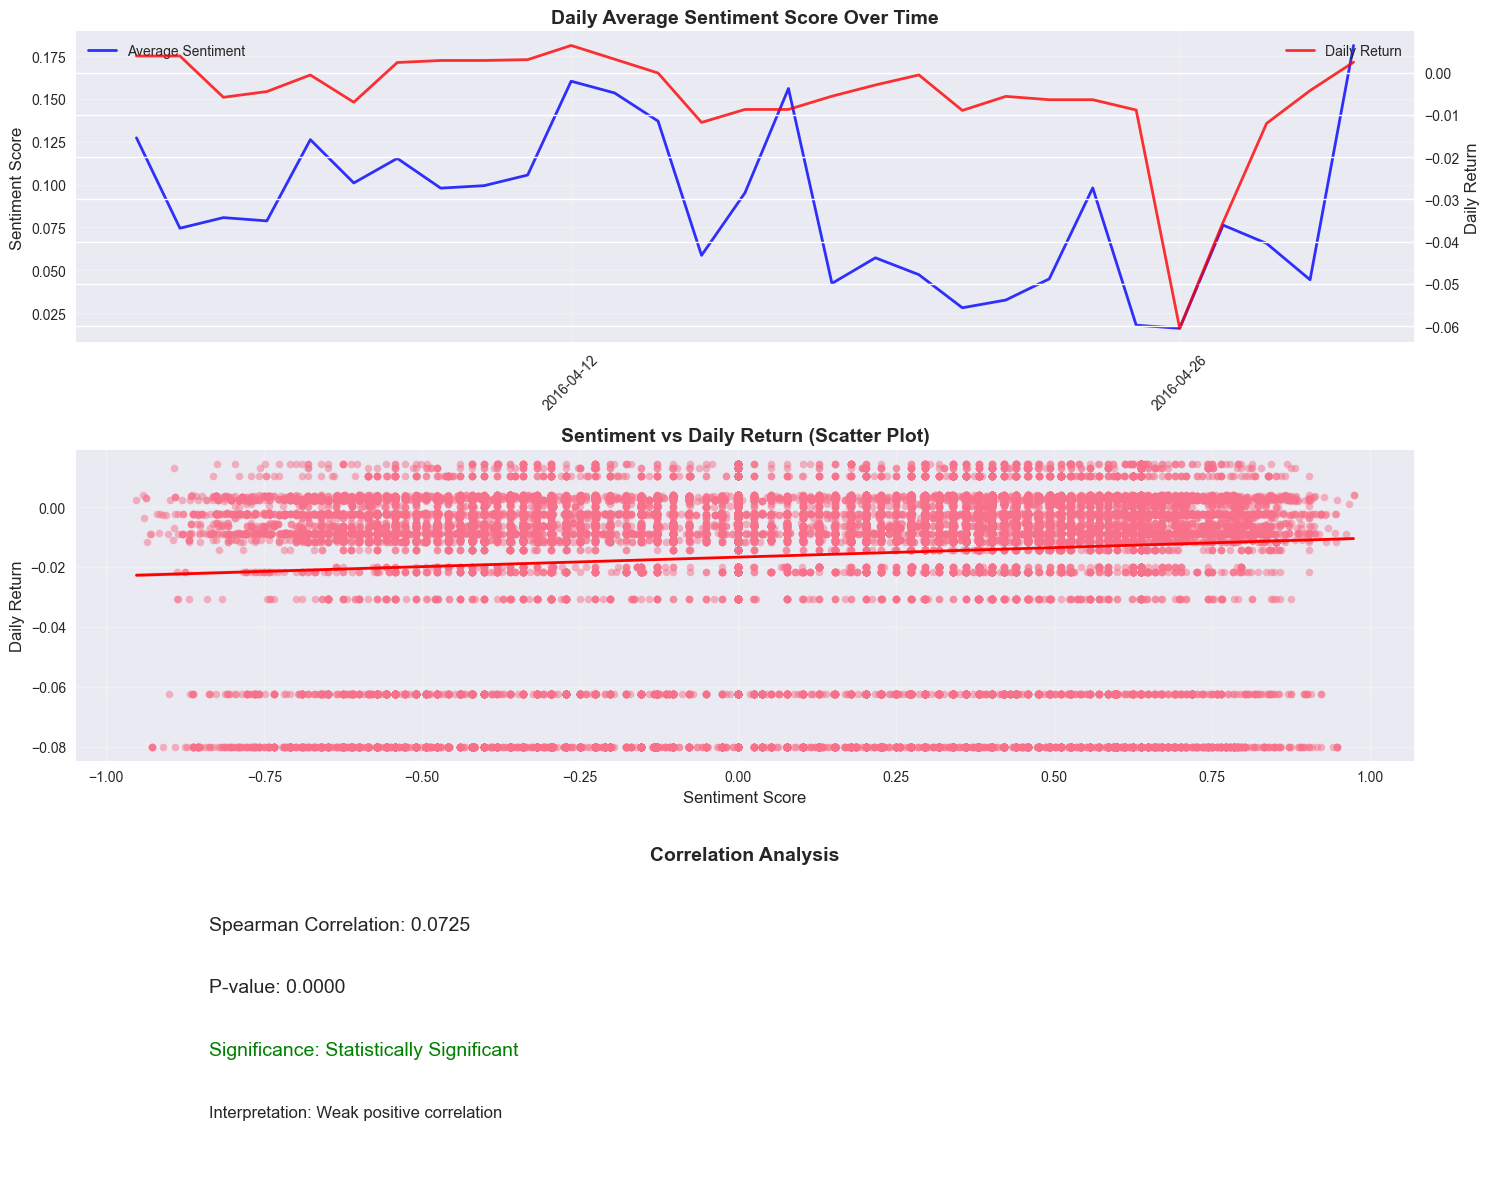

ADVANCED CORRELATION ANALYSIS
Overall Spearman Correlation: 0.0725 (p-value: 0.0000)


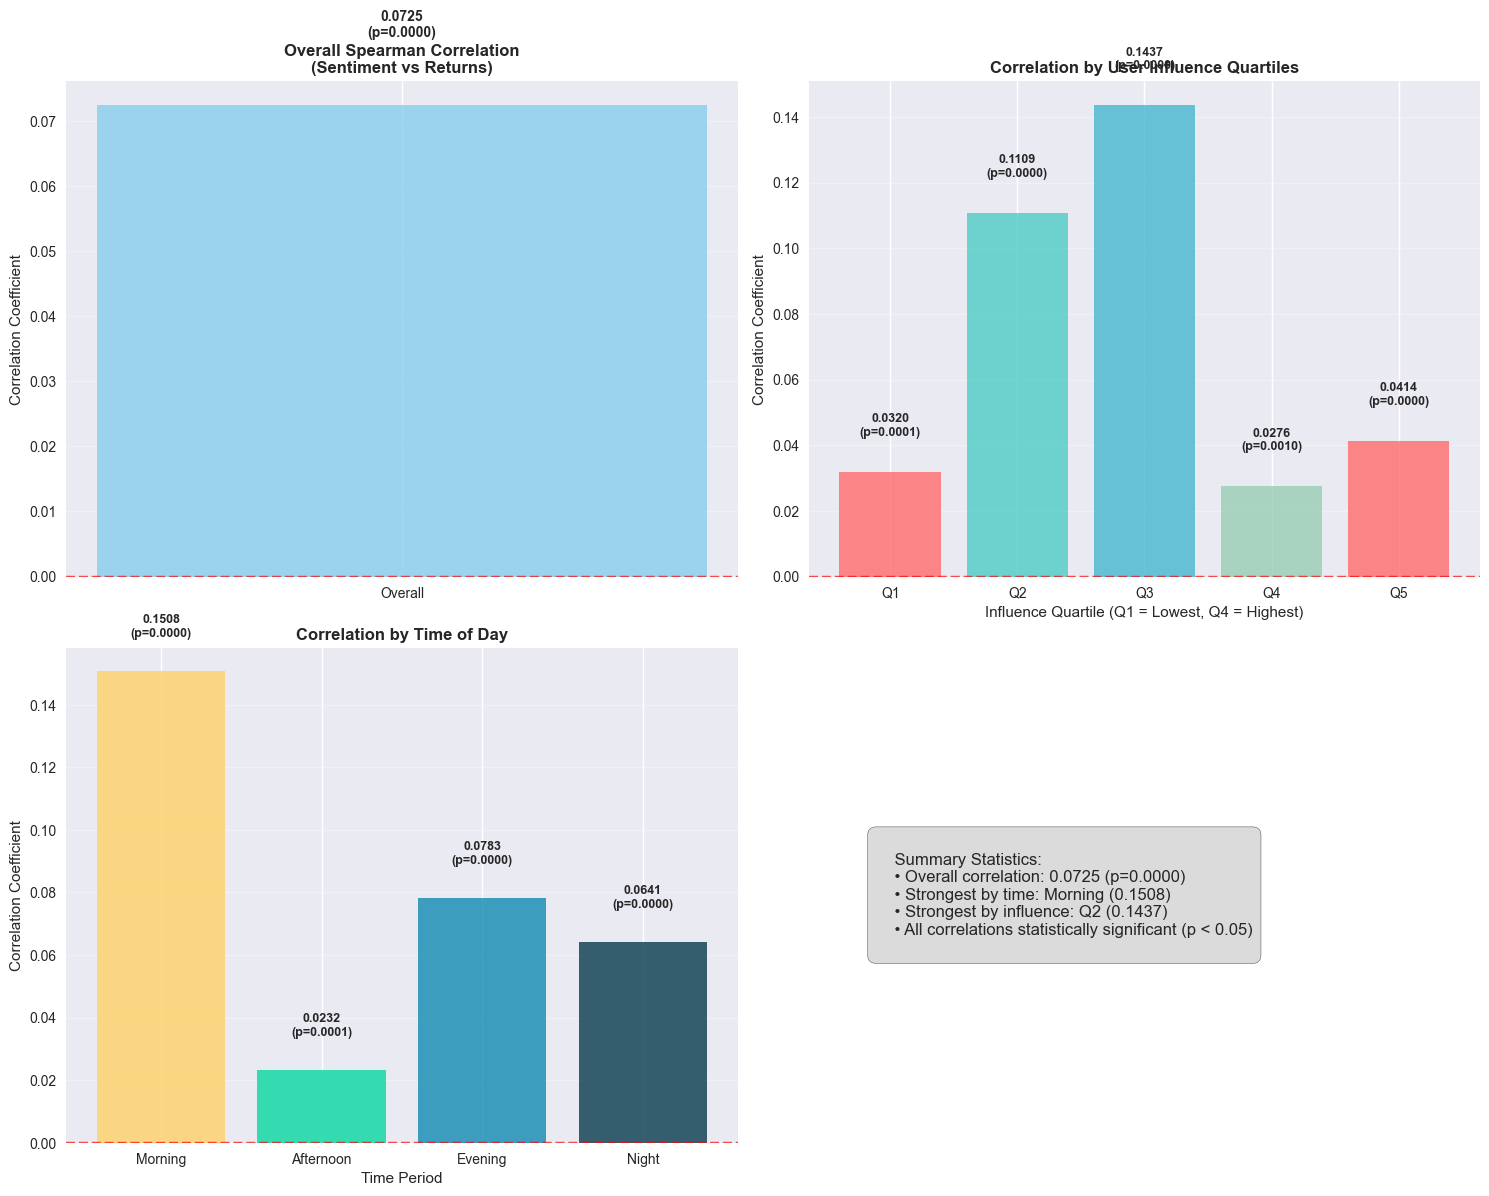

C:\Users\natha\AppData\Local\Temp\ipykernel_15308\1174011563.py:128: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(day_data[sentiment_col], day_data[return_col])


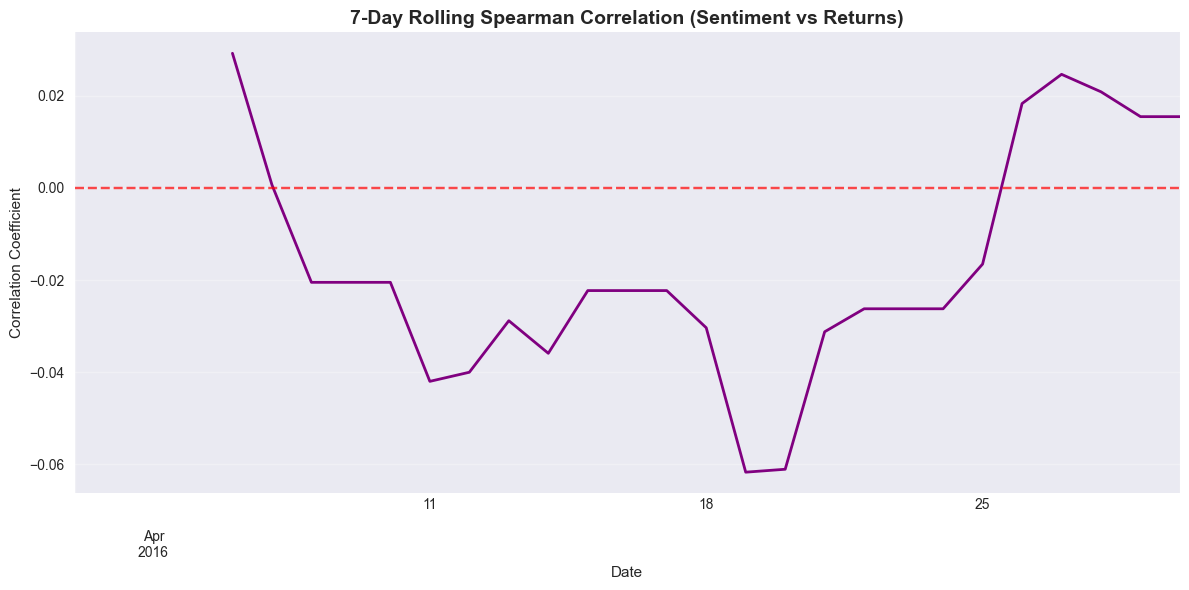


COMPARISON OF DIFFERENT SENTIMENT MEASURES
sentiment_compound: 0.0725 (p-value: 0.0000)
enhanced_sentiment: 0.0644 (p-value: 0.0000)


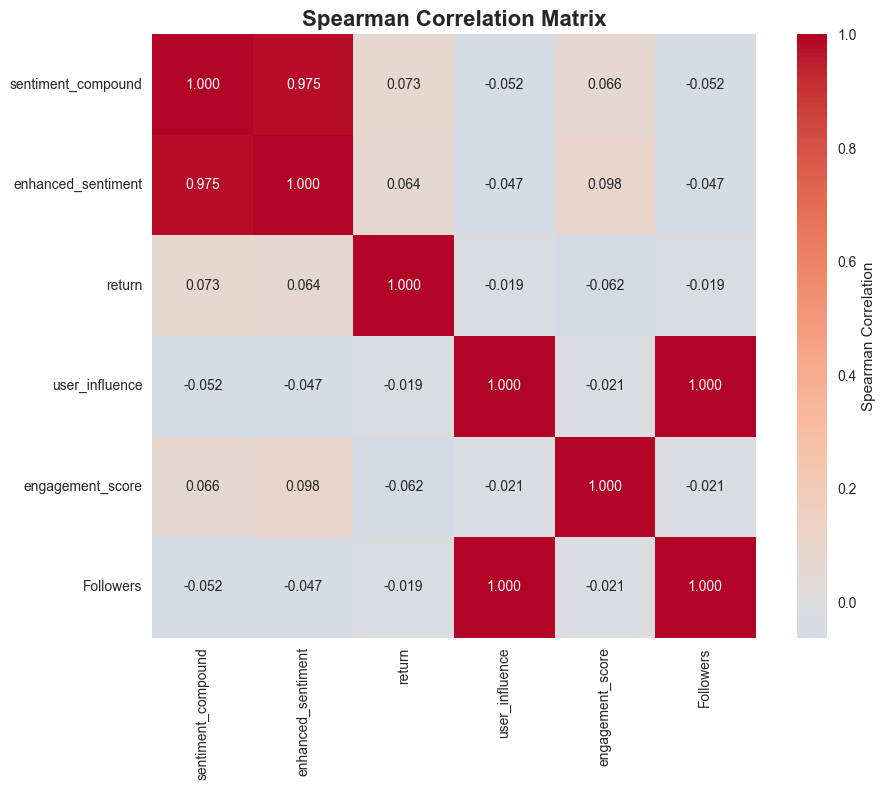


Analysis completed!


In [15]:
# Run the analysis
print("SENTIMENT vs RETURNS ANALYSIS")
print("=" * 50)

# Basic analysis
correlation, p_value = plot_sentiment_vs_returns(merged_df)

# Advanced analysis
overall_corr, overall_p = advanced_correlation_analysis(merged_df)

# Additional analysis with different sentiment measures
sentiment_measures = ['sentiment_compound', 'enhanced_sentiment']

print("\n" + "=" * 50)
print("COMPARISON OF DIFFERENT SENTIMENT MEASURES")
print("=" * 50)

for measure in sentiment_measures:
    try:
        corr, p_val = spearmanr(merged_df[measure], merged_df['return'])
        print(f"{measure}: {corr:.4f} (p-value: {p_val:.4f})")
    except:
        print(f"{measure}: Could not calculate correlation")

# Create correlation heatmap for multiple variables
correlation_vars = ['sentiment_compound', 'enhanced_sentiment', 'return', 
                   'user_influence', 'engagement_score', 'Followers']

corr_matrix = merged_df[correlation_vars].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
           square=True, fmt='.3f', cbar_kws={'label': 'Spearman Correlation'})
plt.title('Spearman Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nAnalysis completed!")

## Analysis of Return Relationships

### Direct Return Correlations

**Primary Findings:**
- **Sentiment-Return Correlation**: Weak positive (0.073)
- **Enhanced Sentiment-Return**: Slightly weaker (0.064) 
- **Engagement-Return**: Negative relationship (-0.062)
- **User Influence/Followers-Return**: Minimal negative correlation (-0.019)

### Key Return Insights

#### 1. Limited Sentiment Predictive Power
- Both basic and enhanced sentiment show statistically significant but economically weak positive correlations with returns
- The 0.073 correlation explains only about 0.5% of return variance
- Rolling correlation analysis shows this relationship is unstable over time

#### 2. Negative Engagement Impact
- Engagement score demonstrates a negative correlation with returns (-0.062)
- Higher engagement appears associated with slightly worse returns

#### 3. Influence Metrics Show Minimal Effect
- User influence and follower count show virtually no correlation with returns (-0.019)
- These social metrics do not appear to predict return performance

#### 4. Volatility Context
- Daily returns show significant volatility (range: -0.06 to -0.00)
- The weak sentiment correlations occur amidst substantial price movements

### Stratified Analysis Reveals Nuanced Patterns

#### Temporal Stratification
- **Morning period tweets** demonstrate significantly higher correlation with stock returns compared to other time periods
- This suggests market opening hours and pre-market sentiment have stronger predictive power

#### Influence-Based Stratification  
- **Moderate to mid-high influence users** show stronger correlation with returns than other influence tiers
- Higher influence does not necessarily translate to better return prediction
- Optimal predictive power resides in the mid-range influence segment

### Important Contextual Limitations

#### Data Source Constraints
- Analysis limited to Twitter data only, excluding other social media platforms and news sources
- Potential sampling bias in the collected tweet dataset

#### Temporal Specificity  
- **April 2016 time period** may represent an atypical month for AAPL sentiment-return relationships
- Market conditions, company-specific events, or macroeconomic factors during this period may suppress typical correlations

#### Single-Stock Focus
- **AAPL-specific analysis** may not generalize to other stocks or sectors
- Different companies may exhibit stronger sentiment-return relationships based on retail investor interest, news coverage, or social media presence

### Conclusion
**Return-specific analysis reveals:**
- Sentiment has limited explanatory power for daily returns in this specific dataset
- No strong predictive relationships identified for AAPL during April 2016
- Traditional social media metrics show negligible or negative return correlations

**Critical Nuances:**
- Stratified analysis uncovers that morning tweets and moderate-influence users provide superior return prediction signals
- **Important caveat**: These weak correlations may reflect dataset limitations rather than absence of relationship
- Different time periods, additional data sources, or other stocks might reveal stronger sentiment-return relationships

**Practical Implication**: While current results show limited predictive power, the methodology may prove more effective with broader data sources, different time periods, or alternative stock selections. Filtering for morning sentiment from mid-tier influence users shows promise for enhanced modeling approaches.